# CAP 350 - Data Engineering - Capstone Project 

Overview:

This Capstone Project requires learners to work with the following technologies to `manage an ETL process` for a `Loan Application dataset` and a `Credit Card dataset`: Python (Pandas, advanced modules, e.g., Matplotlib), SQL, Apache Spark (Spark Core, Spark SQL), and Python Visualization and Analytics libraries. Learners are expected to set up their environments and perform installations on their local machines.

`Credit Card Dataset Overview`

The Credit Card System database is an independent system developed for managing activities such as registering new customers and approving or canceling requests, etc., using the architecture.

A credit card is issued to users to enact the payment system. It allows the cardholder to access financial services in exchange for the holder's promise to pay for them later. Below are three files that contain the customer’s transaction information and inventories in the credit card information.

- 	`CDW_SAPP_CUSTOMER.JSON`: This file has the existing customer details.
- 	`CDW_SAPP_CREDITCARD.JSON`: This file contains all credit card transaction information.
- 	`CDW_SAPP_BRANCH.JSON`: Each branch’s information and details are recorded in this file. 


### Business Requirements - ETL
### 1. Functional Requirements - Load Credit Card Database (SQL)


1.1 - Data Extraction and Transformation with Python and PySpark

a)	For “Credit Card System,” create a Python and PySpark SQL program to read/extract the following JSON files according to the specifications found in the mapping document.

- Hint: [You can use  PySQL “select statement query” or simple Pyspark RDD].


In [1]:
!.\venv\Scripts\activate


In [2]:
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.sql import SparkSession
ss = SparkSession.builder.appName("Credit_Card_System").getOrCreate()
ss


In [2]:
# import and read json files into pyspark df
# json files don't have the same concept of column headers as csv files and is a self-describing data format, hence no need to specify header and infer schema
branch = ss.read.json("cdw_sapp_branch.json")
credit = ss.read.json("cdw_sapp_credit.json")
customer = ss.read.json("cdw_sapp_customer.json")


In [12]:
# inspect data in branch df
branch.printSchema()
print(branch.schema)
branch.show(5, truncate=False)


root
 |-- BRANCH_CITY: string (nullable = true)
 |-- BRANCH_CODE: long (nullable = true)
 |-- BRANCH_NAME: string (nullable = true)
 |-- BRANCH_PHONE: string (nullable = true)
 |-- BRANCH_STATE: string (nullable = true)
 |-- BRANCH_STREET: string (nullable = true)
 |-- BRANCH_ZIP: long (nullable = true)
 |-- LAST_UPDATED: string (nullable = true)

StructType([StructField('BRANCH_CITY', StringType(), True), StructField('BRANCH_CODE', LongType(), True), StructField('BRANCH_NAME', StringType(), True), StructField('BRANCH_PHONE', StringType(), True), StructField('BRANCH_STATE', StringType(), True), StructField('BRANCH_STREET', StringType(), True), StructField('BRANCH_ZIP', LongType(), True), StructField('LAST_UPDATED', StringType(), True)])
+-----------------+-----------+------------+------------+------------+-----------------+----------+-----------------------------+
|BRANCH_CITY      |BRANCH_CODE|BRANCH_NAME |BRANCH_PHONE|BRANCH_STATE|BRANCH_STREET    |BRANCH_ZIP|LAST_UPDATED            

In [13]:
branch.filter(isnull(branch['BRANCH_ZIP'])).show(truncate=False)


+-----------+-----------+-----------+------------+------------+-------------+----------+------------+
|BRANCH_CITY|BRANCH_CODE|BRANCH_NAME|BRANCH_PHONE|BRANCH_STATE|BRANCH_STREET|BRANCH_ZIP|LAST_UPDATED|
+-----------+-----------+-----------+------------+------------+-------------+----------+------------+
+-----------+-----------+-----------+------------+------------+-------------+----------+------------+



In [3]:
test = branch.withColumns({'BRANCH_CODE': branch['BRANCH_CODE'].cast(IntegerType()),
                           'BRANCH_NAME': branch['BRANCH_NAME'].cast(VarcharType(length=150))})  # same as StringType(), leave as it is
test.printSchema()
[test.schema]


root
 |-- BRANCH_CITY: string (nullable = true)
 |-- BRANCH_CODE: integer (nullable = true)
 |-- BRANCH_NAME: string (nullable = true)
 |-- BRANCH_PHONE: string (nullable = true)
 |-- BRANCH_STATE: string (nullable = true)
 |-- BRANCH_STREET: string (nullable = true)
 |-- BRANCH_ZIP: long (nullable = true)
 |-- LAST_UPDATED: string (nullable = true)



[StructType([StructField('BRANCH_CITY', StringType(), True), StructField('BRANCH_CODE', IntegerType(), True), StructField('BRANCH_NAME', StringType(), True), StructField('BRANCH_PHONE', StringType(), True), StructField('BRANCH_STATE', StringType(), True), StructField('BRANCH_STREET', StringType(), True), StructField('BRANCH_ZIP', LongType(), True), StructField('LAST_UPDATED', StringType(), True)])]

In [4]:
# convert phone number formatting to (xxx)xxx-xxxx
branch = branch.withColumn('BRANCH_PHONE', concat(lit("("), substring(col('BRANCH_PHONE'), 1, 3), lit(")"),
                                                  substring(col('BRANCH_PHONE'), 4, 3), lit("-"), substring(col('BRANCH_PHONE'), 7, 4)))

# replace null values in branch_zip column with 99999, df.fillna() updates the df in-place
branch.fillna({'BRANCH_ZIP': 99999})

# transform data type and rearrange columns
branch = branch.select(branch["BRANCH_CODE"].cast(IntegerType()),
                       "BRANCH_NAME",
                       "BRANCH_STREET",
                       "BRANCH_CITY",
                       "BRANCH_STATE",
                       branch["BRANCH_ZIP"].cast(IntegerType()),
                       "BRANCH_PHONE",
                       branch["LAST_UPDATED"].cast(TimestampType()))

# inspect new df
branch.printSchema()
branch.show(15)
branch.filter(isnull(branch['BRANCH_ZIP'])).show(5)


root
 |-- BRANCH_CODE: integer (nullable = true)
 |-- BRANCH_NAME: string (nullable = true)
 |-- BRANCH_STREET: string (nullable = true)
 |-- BRANCH_CITY: string (nullable = true)
 |-- BRANCH_STATE: string (nullable = true)
 |-- BRANCH_ZIP: integer (nullable = true)
 |-- BRANCH_PHONE: string (nullable = true)
 |-- LAST_UPDATED: timestamp (nullable = true)



+-----------+------------+-----------------+-----------------+------------+----------+-------------+-------------------+
|BRANCH_CODE| BRANCH_NAME|    BRANCH_STREET|      BRANCH_CITY|BRANCH_STATE|BRANCH_ZIP| BRANCH_PHONE|       LAST_UPDATED|
+-----------+------------+-----------------+-----------------+------------+----------+-------------+-------------------+
|          1|Example Bank|     Bridle Court|        Lakeville|          MN|     55044|(123)456-5276|2018-04-18 13:51:47|
|          2|Example Bank|Washington Street|          Huntley|          IL|     60142|(123)461-8993|2018-04-18 13:51:47|
|          3|Example Bank|    Warren Street|SouthRichmondHill|          NY|     11419|(123)498-5926|2018-04-18 13:51:47|
|          4|Example Bank| Cleveland Street|       Middleburg|          FL|     32068|(123)466-3064|2018-04-18 13:51:47|
|          5|Example Bank|      14th Street|    KingOfPrussia|          PA|     19406|(123)484-9701|2018-04-18 13:51:47|
|          7|Example Bank| Jeffe

In [16]:
# inspect data in credit df
credit.printSchema()
print(credit.schema)
credit.show(5, truncate=False)


root
 |-- BRANCH_CODE: long (nullable = true)
 |-- CREDIT_CARD_NO: string (nullable = true)
 |-- CUST_SSN: long (nullable = true)
 |-- DAY: long (nullable = true)
 |-- MONTH: long (nullable = true)
 |-- TRANSACTION_ID: long (nullable = true)
 |-- TRANSACTION_TYPE: string (nullable = true)
 |-- TRANSACTION_VALUE: double (nullable = true)
 |-- YEAR: long (nullable = true)

StructType([StructField('BRANCH_CODE', LongType(), True), StructField('CREDIT_CARD_NO', StringType(), True), StructField('CUST_SSN', LongType(), True), StructField('DAY', LongType(), True), StructField('MONTH', LongType(), True), StructField('TRANSACTION_ID', LongType(), True), StructField('TRANSACTION_TYPE', StringType(), True), StructField('TRANSACTION_VALUE', DoubleType(), True), StructField('YEAR', LongType(), True)])
+-----------+----------------+---------+---+-----+--------------+----------------+-----------------+----+
|BRANCH_CODE|CREDIT_CARD_NO  |CUST_SSN |DAY|MONTH|TRANSACTION_ID|TRANSACTION_TYPE|TRANSACTION_

In [5]:
# add new column concatenating year-month-day
credit = credit.withColumn('TIMEID', concat(col('YEAR'), lit(
    '-'), col('MONTH'), lit('-'), col('DAY')).cast(DateType()))
credit.show(5)


+-----------+----------------+---------+---+-----+--------------+----------------+-----------------+----+----------+
|BRANCH_CODE|  CREDIT_CARD_NO| CUST_SSN|DAY|MONTH|TRANSACTION_ID|TRANSACTION_TYPE|TRANSACTION_VALUE|YEAR|    TIMEID|
+-----------+----------------+---------+---+-----+--------------+----------------+-----------------+----+----------+
|        114|4210653349028689|123459988| 14|    2|             1|       Education|             78.9|2018|2018-02-14|
|         35|4210653349028689|123459988| 20|    3|             2|   Entertainment|            14.24|2018|2018-03-20|
|        160|4210653349028689|123459988|  8|    7|             3|         Grocery|             56.7|2018|2018-07-08|
|        114|4210653349028689|123459988| 19|    4|             4|   Entertainment|            59.73|2018|2018-04-19|
|         93|4210653349028689|123459988| 10|   10|             5|             Gas|             3.59|2018|2018-10-10|
+-----------+----------------+---------+---+-----+--------------

In [6]:
# transform data type and rearrange columns
credit = credit.select(credit['CREDIT_CARD_NO'].alias("CUST_CC_NO"),
                       credit['TIMEID'],
                       credit['CUST_SSN'].cast(IntegerType()),
                       credit['BRANCH_CODE'].cast(IntegerType()),
                       credit['TRANSACTION_TYPE'],
                       credit['TRANSACTION_VALUE'],
                       credit['TRANSACTION_ID'].cast(IntegerType()))

# inspect new df
credit.printSchema()
credit.show(15, truncate=False)


root
 |-- CUST_CC_NO: string (nullable = true)
 |-- TIMEID: date (nullable = true)
 |-- CUST_SSN: integer (nullable = true)
 |-- BRANCH_CODE: integer (nullable = true)
 |-- TRANSACTION_TYPE: string (nullable = true)
 |-- TRANSACTION_VALUE: double (nullable = true)
 |-- TRANSACTION_ID: integer (nullable = true)

+----------------+----------+---------+-----------+----------------+-----------------+--------------+
|CUST_CC_NO      |TIMEID    |CUST_SSN |BRANCH_CODE|TRANSACTION_TYPE|TRANSACTION_VALUE|TRANSACTION_ID|
+----------------+----------+---------+-----------+----------------+-----------------+--------------+
|4210653349028689|2018-02-14|123459988|114        |Education       |78.9             |1             |
|4210653349028689|2018-03-20|123459988|35         |Entertainment   |14.24            |2             |
|4210653349028689|2018-07-08|123459988|160        |Grocery         |56.7             |3             |
|4210653349028689|2018-04-19|123459988|114        |Entertainment   |59.73  

In [19]:
# inspect data in customer df
customer.printSchema()
print(customer.schema)
customer.show(5, truncate=False)


root
 |-- APT_NO: string (nullable = true)
 |-- CREDIT_CARD_NO: string (nullable = true)
 |-- CUST_CITY: string (nullable = true)
 |-- CUST_COUNTRY: string (nullable = true)
 |-- CUST_EMAIL: string (nullable = true)
 |-- CUST_PHONE: long (nullable = true)
 |-- CUST_STATE: string (nullable = true)
 |-- CUST_ZIP: string (nullable = true)
 |-- FIRST_NAME: string (nullable = true)
 |-- LAST_NAME: string (nullable = true)
 |-- LAST_UPDATED: string (nullable = true)
 |-- MIDDLE_NAME: string (nullable = true)
 |-- SSN: long (nullable = true)
 |-- STREET_NAME: string (nullable = true)

StructType([StructField('APT_NO', StringType(), True), StructField('CREDIT_CARD_NO', StringType(), True), StructField('CUST_CITY', StringType(), True), StructField('CUST_COUNTRY', StringType(), True), StructField('CUST_EMAIL', StringType(), True), StructField('CUST_PHONE', LongType(), True), StructField('CUST_STATE', StringType(), True), StructField('CUST_ZIP', StringType(), True), StructField('FIRST_NAME', Stri

In [5]:
test = customer.withColumn('CUST_PHONE', concat(
    lit('('), col('CUST_PHONE')[0:3], lit(')')))
test.show(5)


+------+----------------+------------+-------------+-------------------+----------+----------+--------+----------+---------+--------------------+-----------+---------+-----------------+
|APT_NO|  CREDIT_CARD_NO|   CUST_CITY| CUST_COUNTRY|         CUST_EMAIL|CUST_PHONE|CUST_STATE|CUST_ZIP|FIRST_NAME|LAST_NAME|        LAST_UPDATED|MIDDLE_NAME|      SSN|      STREET_NAME|
+------+----------------+------------+-------------+-------------------+----------+----------+--------+----------+---------+--------------------+-----------+---------+-----------------+
|   656|4210653310061055|     Natchez|United States|AHooper@example.com|     (123)|        MS|   39120|      Alec|   Hooper|2018-04-21T12:49:...|         Wm|123456100|Main Street North|
|   829|4210653310102868|Wethersfield|United States|EHolman@example.com|     (123)|        CT|   06109|      Etta|   Holman|2018-04-21T12:49:...|    Brendan|123453023|    Redwood Drive|
|   683|4210653310116272|     Huntley|United States|WDunham@example.co

In [7]:
# change the case of strings and convert phone number formatting to (xxx)xxx-xxxx
customer = customer.withColumns({'FIRST_NAME': initcap(col('FIRST_NAME')),
                                 'MIDDLE_NAME': lower(col('MIDDLE_NAME')),
                                 'LAST_NAME': initcap(col('LAST_NAME')),
                                 'FULL_STREET_ADDRESS': concat(col('STREET_NAME'), lit(', '), col('APT_NO')),
                                 'CUST_PHONE': concat(lit('(XXX)'), col('CUST_PHONE')[0:3], lit('-'), col('CUST_PHONE')[4:7])})  # phone num is missing area code

customer.show(5, truncate=False)


+------+----------------+------------+-------------+-------------------+-------------+----------+--------+----------+---------+-----------------------------+-----------+---------+-----------------+----------------------+
|APT_NO|CREDIT_CARD_NO  |CUST_CITY   |CUST_COUNTRY |CUST_EMAIL         |CUST_PHONE   |CUST_STATE|CUST_ZIP|FIRST_NAME|LAST_NAME|LAST_UPDATED                 |MIDDLE_NAME|SSN      |STREET_NAME      |FULL_STREET_ADDRESS   |
+------+----------------+------------+-------------+-------------------+-------------+----------+--------+----------+---------+-----------------------------+-----------+---------+-----------------+----------------------+
|656   |4210653310061055|Natchez     |United States|AHooper@example.com|(XXX)123-7818|MS        |39120   |Alec      |Hooper   |2018-04-21T12:49:02.000-04:00|wm         |123456100|Main Street North|Main Street North, 656|
|829   |4210653310102868|Wethersfield|United States|EHolman@example.com|(XXX)123-8933|CT        |06109   |Etta      

In [8]:
# transform data type and rearrange columns
customer = customer.select(col('SSN').cast(IntegerType()),
                           'FIRST_NAME',
                           'MIDDLE_NAME',
                           'LAST_NAME',
                           'CREDIT_CARD_NO',
                           'FULL_STREET_ADDRESS',
                           'CUST_CITY',
                           'CUST_STATE',
                           'CUST_COUNTRY',
                           col('CUST_ZIP').cast(IntegerType()),
                           col('CUST_PHONE').cast(VarcharType(length=20)),
                           'CUST_EMAIL',
                           col('LAST_UPDATED').cast(TimestampType()))

# inspect new df
customer.printSchema()
customer.show(15, truncate=False)


root
 |-- SSN: integer (nullable = true)
 |-- FIRST_NAME: string (nullable = true)
 |-- MIDDLE_NAME: string (nullable = true)
 |-- LAST_NAME: string (nullable = true)
 |-- CREDIT_CARD_NO: string (nullable = true)
 |-- FULL_STREET_ADDRESS: string (nullable = true)
 |-- CUST_CITY: string (nullable = true)
 |-- CUST_STATE: string (nullable = true)
 |-- CUST_COUNTRY: string (nullable = true)
 |-- CUST_ZIP: integer (nullable = true)
 |-- CUST_PHONE: string (nullable = true)
 |-- CUST_EMAIL: string (nullable = true)
 |-- LAST_UPDATED: timestamp (nullable = true)



+---------+----------+-----------+---------+----------------+----------------------+------------+----------+-------------+--------+-------------+---------------------+-------------------+
|SSN      |FIRST_NAME|MIDDLE_NAME|LAST_NAME|CREDIT_CARD_NO  |FULL_STREET_ADDRESS   |CUST_CITY   |CUST_STATE|CUST_COUNTRY |CUST_ZIP|CUST_PHONE   |CUST_EMAIL           |LAST_UPDATED       |
+---------+----------+-----------+---------+----------------+----------------------+------------+----------+-------------+--------+-------------+---------------------+-------------------+
|123456100|Alec      |wm         |Hooper   |4210653310061055|Main Street North, 656|Natchez     |MS        |United States|39120   |(XXX)123-7818|AHooper@example.com  |2018-04-21 09:49:02|
|123453023|Etta      |brendan    |Holman   |4210653310102868|Redwood Drive, 829    |Wethersfield|CT        |United States|6109    |(XXX)123-8933|EHolman@example.com  |2018-04-21 09:49:02|
|123454487|Wilber    |ezequiel   |Dunham   |4210653310116272

1.2 - Data loading into Database 

Once PySpark reads data from JSON files, and then utilizes Python, PySpark, and Python modules to load data into RDBMS(SQL), perform the following:
 
a)	Create a Database in SQL(MySQL), named “creditcard_capstone.”


In [3]:
# import mysql.connector
# from mysql.connector import Error, errorcode
# import os

# # def connect_to_mysql():
# try:
#     # establish a connection to mysql db
#     cnx = mysql.connector.connect(host = 'localhost',
#                                   user = os.environ.get('MYSQL_DB_USER'),
#                                   password = os.environ.get('MYSQL_DB_PW'))

#     if cnx.is_connected():
#         print("Connection established.")
#     else:
#         print("Connection failed.")

# except Error as e:
#         print(e)


Connection established.


In [10]:
# # def create_db(cnx):
# try:
#     # create cursor obj to execute sql query
#     cursor = cnx.cursor()
#     # query to create new db
#     cursor.execute("CREATE DATABASE IF NOT EXISTS creditcard_capstone")
#     print("Database 'creditcard_capstone' is created.")

# except Error as e:
#     print(f"Failed to create database: {e}")


Database 'creditcard_capstone' is created.


In [ ]:
# # connect to mysql db + create new db
# try:
#     # establish a connection to mysql db
#     cnx = mysql.connector.connect(host = 'localhost',
#                                   user = os.environ.get('MYSQL_DB_USER'),
#                                   password = os.environ.get('MYSQL_DB_PW'))

#     if cnx.is_connected():
#         print("Connection established.")
#         # create cursor obj to execute sql query
#         cursor = cnx.cursor()
#         # query to create new db
#         cursor.execute("CREATE DATABASE IF NOT EXISTS creditcard_capstone")
#         print("Database 'creditcard_capstone' is created.")

# except Error as e:
#         print(e)


In [ ]:
#  MySQL  localhost:33060+ ssl  SQL > SHOW DATABASES;
# +---------------------+
# | Database            |
# +---------------------+
# | classicmodels       |
# | companyabc_db       |
# | creditcard_capstone |   <---
# | information_schema  |
# | mysql               |
# | performance_schema  |
# | sakila              |
# | sys                 |
# | userdb              |
# | world               |
# +---------------------+
# 10 rows in set (0.0025 sec)


In [2]:
import mysql.connector
from mysql.connector import Error
import os


def connect_to_mysql():
    # establish connection to mysql db
    cnx = mysql.connector.connect(host='localhost',
                                  user=os.environ.get('MYSQL_DB_USER'),
                                  password=os.environ.get('MYSQL_DB_PW'))
    return cnx
    # the return statement enables use of the connection outside the function


In [24]:
def create_db(db_name):
    try:
        # the with statement ensures that the connection is automatically closed when the with block is exited, hence no need to explicitly call cnx.close()
        with connect_to_mysql() as cnx:
            # create cursor obj to execute sql query
            cursor = cnx.cursor()
            # query to create new db
            cursor.execute("CREATE DATABASE IF NOT EXISTS db_name")
            print(f"Database {db_name} is created.")

    except Error as e:
        print(e)


create_db("creditcard_capstone")


Database creditcard_capstone is created.



b)	Create a Python and Pyspark Program to load/write the “Credit Card System Data” into RDBMS(creditcard_capstone).

Tables should be created by the following names in RDBMS:
- CDW_SAPP_BRANCH
- CDW_SAPP_CREDIT_CARD
- CDW_SAPP_CUSTOMER 


In [13]:
def load_data():
    with connect_to_mysql() as cnx:
        cursor = cnx.cursor()
        # check if db is empty by counting the num of tables inside
        cursor.execute(
            "select count(distinct table_name) from information_schema.tables where table_schema = 'creditcard_capstone'")
        count = cursor.fetchone()  # fetchone() gets the 1st row = (4,)
        print(count[0])


load_data()


4


In [11]:
# load data from branch df into new table in db
# drop the entire database first if re-runnning/repeating below actions in append mode, otherwise the same set of data will get appended again to the same table, causing duplicates in data
branch.write.format("jdbc")\
    .mode("append")\
    .options(user=os.environ.get("MYSQL_DB_USER"),
             password=os.environ.get("MYSQL_DB_PW"),
             url="jdbc:mysql://localhost:3306/creditcard_capstone",
             dbtable="creditcard_capstone.CDW_SAPP_BRANCH")\
    .save()


In [12]:
# load data from credit df into new table in db
credit.write.format("jdbc")\
    .mode("append")\
    .options(user=os.environ.get("MYSQL_DB_USER"),
             password=os.environ.get("MYSQL_DB_PW"),
             url="jdbc:mysql://localhost:3306/creditcard_capstone",
             dbtable="creditcard_capstone.CDW_SAPP_CREDIT_CARD")\
    .save()


In [13]:
# load data from customer df into new table in db
customer.write.format("jdbc")\
    .mode("append")\
    .options(user=os.environ.get("MYSQL_DB_USER"),
             password=os.environ.get("MYSQL_DB_PW"),
             url="jdbc:mysql://localhost:3306/creditcard_capstone",
             dbtable="creditcard_capstone.CDW_SAPP_CUSTOMER")\
    .save()


In [ ]:
#  MySQL  localhost:33060+ ssl  creditcard_capstone  SQL > SHOW TABLES;
# +-------------------------------+
# | Tables_in_creditcard_capstone |
# +-------------------------------+
# | cdw_sapp_branch               |
# | cdw_sapp_credit_card          |
# | cdw_sapp_customer             |
# +-------------------------------+
# 3 rows in set (0.0024 sec)


### 2. Functional Requirements - Application Front-End
Once data is loaded into the database, we need a front-end (console) to see/display data. For that, create a console-based Python program to satisfy System Requirements 2 (2.1 and 2.2). 

2.1 - Transaction Details Module
- module is a .py file containing Python definitions and statements and can be imported into another module for further use
1. Used to display the transactions made by customers living in a given zip code for a given month and year. Order by day in descending order.


In [3]:
from tabulate import tabulate


In [59]:
def get_trxn_by_zip_mo_yr(zip, mo, yr):
    try:
        with connect_to_mysql() as cnx:
            cursor = cnx.cursor()
            cursor.execute("use creditcard_capstone")
            # use customer as main table here since we are filtering data using customer zip as the primary predicate
            query = f'''select cust.CUST_ZIP, cc.* 
                    from cdw_sapp_customer as cust 
                    left join cdw_sapp_credit_card as cc
                    on cc.cust_ssn = cust.ssn
                    where cust.cust_zip = {zip} and month(cc.timeid) = {mo} and year(cc.timeid) = {yr}
                    order by cc.timeid desc'''
            cursor.execute(query)
            data = cursor.fetchall()
            if data:
                headers = cursor.column_names
                # alternate: headers = [col[0] for col in cursor.description]
                # cursor.description returns something like df.printSchema() or df.columns in rows of tuples, hence header=the 1st column
                table = tabulate(data, headers=headers,
                                 tablefmt="pretty", stralign="left")
                print(table)
            else:
                print("Record not found.")

    except Error as e:
        print(e)


print("Query transaction details by customer zip code, month, and year.")
zip = input("Enter zip code: ")  # try 19438
mo = input("Enter month 'mm': ")  # try 02
yr = input("Enter year 'yyyy': ")  # try 2018
get_trxn_by_zip_mo_yr(zip, mo, yr)


Query transaction details by customer zip code, month, and year.
+----------+------------------+------------+-----------+-------------+------------------+-------------------+----------------+
| CUST_ZIP | CUST_CC_NO       | TIMEID     | CUST_SSN  | BRANCH_CODE | TRANSACTION_TYPE | TRANSACTION_VALUE | TRANSACTION_ID |
+----------+------------------+------------+-----------+-------------+------------------+-------------------+----------------+
| 19438    | 4210653360481256 | 2018-02-26 | 123455001 | 144         | Grocery          | 61.74             | 26068          |
| 19438    | 4210653349028689 | 2018-02-24 | 123459988 | 89          | Healthcare       | 97.98             | 82             |
| 19438    | 4210653338106818 | 2018-02-24 | 123458199 | 124         | Entertainment    | 46.33             | 8989           |
| 19438    | 4210653327324219 | 2018-02-23 | 123458390 | 115         | Bills            | 22.09             | 7902           |
| 19438    | 4210653354321803 | 2018-02-22 | 1

2. Used to display the number and total values of transactions for a given type.


In [156]:
def get_trxn_by_type(type):
    try:
        with connect_to_mysql() as cnx:
            cursor = cnx.cursor()
            cursor.execute("use creditcard_capstone")
            query = f'''select transaction_type as TRXN_TYPE, count(*) as TRXN_COUNT, round(sum(transaction_value),2) as TOTAL_TRXN_VAL
                    from cdw_sapp_credit_card 
                    where transaction_type = '{type}'
                    group by transaction_type'''
            cursor.execute(query)
            data = cursor.fetchall()
            if data:
                # cursor.description returns something like df.printSchema() or df.columns in rows of tuples, hence header=the 1st column
                headers = cursor.column_names
                table = tabulate(data, headers=headers,
                                 tablefmt="pretty", stralign="left")
                print(table)
            else:
                print("Record not found.")

    except Error as e:
        print(e)


print("Query transaction summary by type.")
type = input("Enter transaction type: ")  # try Gas
get_trxn_by_type(type)


Query transaction summary by type.
+-----------+------------+----------------+
| TRXN_TYPE | TRXN_COUNT | TOTAL_TRXN_VAL |
+-----------+------------+----------------+
| Gas       | 6605       | 336059.26      |
+-----------+------------+----------------+


3. Used to display the total number and total values of transactions for branches in a given state.



In [160]:
def get_trxn_by_branch(state):
    try:
        with connect_to_mysql() as cnx:
            cursor = cnx.cursor()
            cursor.execute("use creditcard_capstone")
            # use branch as main table since state is the primary predicate here
            query = f'''select branch_state as BRANCH_STATE, br.branch_code as BRANCH_CODE, branch_name as BRANCH_NAME, count(br.branch_code) as TRXN_COUNT, round(sum(transaction_value),2) as TOTAL_TRXN_VAL 
                    from cdw_sapp_branch as br
                    left join cdw_sapp_credit_card as cc
                    on br.branch_code = cc.branch_code
                    where branch_state = '{state}'
                    group by br.branch_code, branch_name
                    order by TOTAL_TRXN_VAL desc'''
            cursor.execute(query)
            data = cursor.fetchall()
            if data:
                # cursor.description returns something like df.printSchema() or df.columns in rows of tuples, hence header=the 1st column
                headers = cursor.column_names
                table = tabulate(data, headers=headers,
                                 tablefmt="pretty", stralign="left")
                print(table)
            else:
                print("Record not found.")

    except Error as e:
        print(e)


print("Query bank transaction summary by state.")
state = input("Enter state name (2 letters): ")  # try CA
get_trxn_by_branch(state)


Query bank transaction summary by state.
+--------------+-------------+--------------+------------+----------------+
| BRANCH_STATE | BRANCH_CODE | BRANCH_NAME  | TRXN_COUNT | TOTAL_TRXN_VAL |
+--------------+-------------+--------------+------------+----------------+
| CA           | 23          | Example Bank | 434        | 22583.27       |
| CA           | 54          | Example Bank | 412        | 21261.37       |
| CA           | 168         | Example Bank | 409        | 20757.48       |
| CA           | 121         | Example Bank | 398        | 20571.75       |
| CA           | 139         | Example Bank | 398        | 19735.83       |
| CA           | 29          | Example Bank | 373        | 19112.13       |
+--------------+-------------+--------------+------------+----------------+


2.2 - Customer Details Module
1. Used to check the existing account details of a customer.


In [62]:
def get_acct_by_cust(ssn):
    try:
        with connect_to_mysql() as cnx:
            cursor = cnx.cursor()
            cursor.execute("use creditcard_capstone")
            query = f'''select * from cdw_sapp_credit_card where cust_ssn = '{ssn}' order by timeid desc'''
            cursor.execute(query)
            trxn = cursor.fetchall()
            if trxn:
                # print acct trxn details
                t_headers = cursor.column_names
                trxn_table = tabulate(
                    trxn, headers=t_headers, tablefmt="pretty", stralign="left")
                print(trxn_table)
                # print acct holder info
                query = f'''select * from cdw_sapp_customer where ssn = '{ssn}' order by last_updated desc'''
                cursor.execute(query)
                cust = cursor.fetchall()
                c_headers = cursor.column_names
                cust_table = tabulate(
                    cust, headers=c_headers, tablefmt="pretty", stralign="left")
                print(cust_table)
            else:
                print("Record not found.")

    except Error as e:
        print(e)


print("Query account details by customer SSN.")
ssn = input("Enter customer SSN: ")  # try 123459988
get_acct_by_cust(ssn)


Query account details by customer SSN.


+------------------+------------+-----------+-------------+------------------+-------------------+----------------+
| CUST_CC_NO       | TIMEID     | CUST_SSN  | BRANCH_CODE | TRANSACTION_TYPE | TRANSACTION_VALUE | TRANSACTION_ID |
+------------------+------------+-----------+-------------+------------------+-------------------+----------------+
| 4210653349028689 | 2018-12-24 | 123459988 | 17          | Gas              | 42.71             | 12             |
| 4210653349028689 | 2018-12-22 | 123459988 | 121         | Education        | 43.08             | 63             |
| 4210653349028689 | 2018-12-21 | 123459988 | 158         | Healthcare       | 30.58             | 55             |
| 4210653349028689 | 2018-12-18 | 123459988 | 42          | Gas              | 38.07             | 75             |
| 4210653349028689 | 2018-12-14 | 123459988 | 19          | Test             | 82.05             | 27             |
| 4210653349028689 | 2018-12-12 | 123459988 | 66          | Education   

2. Used to modify the existing account details of a customer.


In [8]:
# trxn data is usually auto-captured and non-editable, hence we'll only modify acct holder info here
def modify_acct(ssn, item, update):
    try:
        with connect_to_mysql() as cnx:
            # need to add buffered=True here, otherwise commit will fail and output 'unread result found'
            cursor = cnx.cursor(buffered=True)
            cursor.execute("use creditcard_capstone")
            cursor.execute("select * from cdw_sapp_customer limit 1")
            headers = cursor.column_names  # prints out a tuple of column names
            print(headers)
            # ('SSN', 'FIRST_NAME', 'MIDDLE_NAME', 'LAST_NAME', 'CREDIT_CARD_NO', 'FULL_STREET_ADDRESS', 'CUST_CITY', 'CUST_STATE', 'CUST_COUNTRY', 'CUST_ZIP', 'CUST_PHONE', 'CUST_EMAIL', 'LAST_UPDATED')
            print(item)
            if item in headers and item != 'SSN':
                query = f'''update cdw_sapp_customer set {item} = '{update}' where ssn = '{ssn}' '''
                print(query)
                cursor.execute(query)
                # commit change to db
                cnx.commit()
                print(cursor.rowcount, "record(s) affected")
                cursor.execute(f'''select * from cdw_sapp_customer where ssn = '{ssn}' ''')
                data = cursor.fetchall()
                table = tabulate(data, headers=headers, tablefmt="pretty", stralign="left")
                print(table)
            else:
                print("Commit failed. Item selected not found.")

    except Error as e:
        cnx.rollback()
        print(e)
        # rollback in case there is any error

print("Modify existing account details by customer SSN.")
ssn = input("Enter customer SSN: ")  # try 123459988
item = input("Select the item you want to modify(SSN excluded): ").upper() # try last_name
update = input("Enter new content: ")  # try newchange
modify_acct(ssn, item, update)



('SSN', 'FIRST_NAME', 'MIDDLE_NAME', 'LAST_NAME', 'CREDIT_CARD_NO', 'FULL_STREET_ADDRESS', 'CUST_CITY', 'CUST_STATE', 'CUST_COUNTRY', 'CUST_ZIP', 'CUST_PHONE', 'CUST_EMAIL', 'LAST_UPDATED')
LAST_NAME
update cdw_sapp_customer set LAST_NAME = 'Campos' where ssn = '123459988' 
1 record(s) affected
+-----------+------------+-------------+-----------+------------------+---------------------+--------------+------------+---------------+----------+---------------+---------------------+---------------------+
| SSN       | FIRST_NAME | MIDDLE_NAME | LAST_NAME | CREDIT_CARD_NO   | FULL_STREET_ADDRESS | CUST_CITY    | CUST_STATE | CUST_COUNTRY  | CUST_ZIP | CUST_PHONE    | CUST_EMAIL          | LAST_UPDATED        |
+-----------+------------+-------------+-----------+------------------+---------------------+--------------+------------+---------------+----------+---------------+---------------------+---------------------+
| 123459988 | Amalia     | hal         | Campos    | 4210653349028689 | Valle

3. Used to generate a monthly bill for a credit card number for a given month and year.


In [63]:
def generate_bill_by_ccno_mo_yr(cc_no, mo, yr):
    try:
        with connect_to_mysql() as cnx:
            cursor = cnx.cursor()
            cursor.execute("use creditcard_capstone")
            query = f'''select * from cdw_sapp_credit_card 
                    where cust_cc_no = {cc_no} and month(timeid) = {mo} and year(timeid) = {yr} 
                    order by timeid desc'''
            cursor.execute(query)
            data = cursor.fetchall()
            if data:
                # print monthly bill
                headers = cursor.column_names
                table = tabulate(data, headers=headers,
                                 tablefmt="pretty", stralign="left")
                print(table)
                # print customer info
                query = f'''select distinct * from cdw_sapp_customer where credit_card_no = {cc_no}'''
                cursor.execute(query)
                cust_info = cursor.fetchall()
                headers = cursor.column_names
                cust_table = tabulate(
                    cust_info, headers=headers, tablefmt="pretty", stralign="left")
                print(cust_table)
            else:
                print("Record not found.")

    except Error as e:
        print(e)


print("Query monthly bill by credit card number, month, and year.")
cc_no = input("Enter credit card number:")  # try 4210653349028689
mo = input("Enter month 'mm':")  # try 12
yr = input("Enter month 'yyyy':")  # try 2018
generate_bill_by_ccno_mo_yr(cc_no, mo, yr)


Query monthly bill by credit card number, month, and year.
+------------------+------------+-----------+-------------+------------------+-------------------+----------------+
| CUST_CC_NO       | TIMEID     | CUST_SSN  | BRANCH_CODE | TRANSACTION_TYPE | TRANSACTION_VALUE | TRANSACTION_ID |
+------------------+------------+-----------+-------------+------------------+-------------------+----------------+
| 4210653349028689 | 2018-12-24 | 123459988 | 17          | Gas              | 42.71             | 12             |
| 4210653349028689 | 2018-12-22 | 123459988 | 121         | Education        | 43.08             | 63             |
| 4210653349028689 | 2018-12-21 | 123459988 | 158         | Healthcare       | 30.58             | 55             |
| 4210653349028689 | 2018-12-18 | 123459988 | 42          | Gas              | 38.07             | 75             |
| 4210653349028689 | 2018-12-14 | 123459988 | 19          | Test             | 82.05             | 27             |
| 42106533490

4. Used to display the transactions made by a customer between two dates. Order by year, month, and day in descending order.


In [64]:
def get_trxn_by_ssn_and_date(ssn, d1, d2):
    try:
        with connect_to_mysql() as cnx:
            cursor = cnx.cursor()
            cursor.execute("use creditcard_capstone")
            query = f'''select * from cdw_sapp_credit_card 
                    where cust_ssn = {ssn} and timeid between '{d1}' and '{d2}'
                    order by timeid desc'''
            cursor.execute(query)
            data = cursor.fetchall()
            if data:
                headers = cursor.column_names
                table = tabulate(data, headers=headers,
                                 tablefmt="pretty", stralign="left")
                print(table)
            else:
                print("Record not found.")

    except Error as e:
        print(e)


print("Query transaction details by customer SSN and date range.")
ssn = input("Enter customer SSN: ")  # try 123459988
d1 = input("From (yyyy-mm-dd): ")  # try 2018-12-04
d2 = input("To (yyyy-mm-dd): ")  # try 2018-12-24
get_trxn_by_ssn_and_date(ssn, d1, d2)


Query transaction details by customer SSN and date range.
+------------------+------------+-----------+-------------+------------------+-------------------+----------------+
| CUST_CC_NO       | TIMEID     | CUST_SSN  | BRANCH_CODE | TRANSACTION_TYPE | TRANSACTION_VALUE | TRANSACTION_ID |
+------------------+------------+-----------+-------------+------------------+-------------------+----------------+
| 4210653349028689 | 2018-12-24 | 123459988 | 17          | Gas              | 42.71             | 12             |
| 4210653349028689 | 2018-12-22 | 123459988 | 121         | Education        | 43.08             | 63             |
| 4210653349028689 | 2018-12-21 | 123459988 | 158         | Healthcare       | 30.58             | 55             |
| 4210653349028689 | 2018-12-18 | 123459988 | 42          | Gas              | 38.07             | 75             |
| 4210653349028689 | 2018-12-14 | 123459988 | 19          | Test             | 82.05             | 27             |
| 421065334902

### 3. Functional Requirements - Data Analysis and Visualization
After data is loaded into the database, users can make changes from the front end, and they can also view data from the front end. Now, the business analyst team wants to analyze and visualize the data.

Use Python libraries for the below requirements:

3.1 - Find and plot which transaction type has the highest transaction count.

Note: Save a copy of the visualization to a folder in your github, making sure it is PROPERLY NAMED! 


In [21]:
import matplotlib.pyplot as plt
from matplotlib import style


+---------------+-----------+
| TRXN_TYPE     | NUM_TRXNS |
+---------------+-----------+
| Bills         | 6861      |
| Healthcare    | 6723      |
| Test          | 6683      |
| Education     | 6638      |
| Entertainment | 6635      |
| Gas           | 6605      |
| Grocery       | 6549      |
+---------------+-----------+


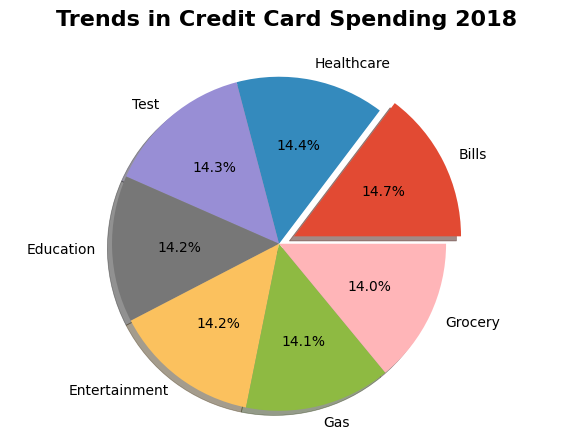

In [31]:
def view_trxn_type():
    try:
        with connect_to_mysql() as cnx:
            cursor = cnx.cursor()
            cursor.execute("use creditcard_capstone")
            query = '''select transaction_type as TRXN_TYPE, count(distinct transaction_id) as NUM_TRXNS
                    from cdw_sapp_credit_card
                    group by TRXN_TYPE
                    order by NUM_TRXNS desc'''
            cursor.execute(query)
            data = cursor.fetchall()
            if data:
                headers = cursor.column_names
                table = tabulate(data, headers=headers,
                                 tablefmt="pretty", stralign="left")
                print(table)
                # create data visualization
                trxn_type = [row[0] for row in data]  # pie labels
                trxn_count = [row[1] for row in data]  # pie sizes
                plt.style.use('ggplot')
                plt.figure(3.1, figsize=(6, 4.5), layout='tight')
                # make a slice pop out
                explode = (0.1, 0, 0, 0, 0, 0, 0)
                plt.pie(trxn_count, explode=explode, labels=trxn_type,
                        autopct='%1.1f%%', shadow=True)
                plt.title("Trends in Credit Card Spending 2018",
                          fontsize=16, fontweight='bold', pad=25)
                plt.axis('equal')
                plt.show()

    except Error as e:
        print(e)


view_trxn_type()


3.2 - Find and plot which state has a high number of customers.

Note: Save a copy of the visualization to a folder in your github, making sure it is PROPERLY NAMED!


+--------------+----------+
| BRANCH_STATE | NUM_CUST |
+--------------+----------+
| PA           | 868      |
| FL           | 843      |
| NY           | 840      |
| MI           | 824      |
| OH           | 804      |
| IL           | 784      |
| CA           | 782      |
| NJ           | 754      |
| GA           | 743      |
| TX           | 735      |
| MD           | 722      |
| NC           | 711      |
| IA           | 692      |
| WI           | 691      |
| SC           | 633      |
| MS           | 627      |
| MN           | 574      |
| MA           | 519      |
| VA           | 514      |
| WA           | 511      |
| IN           | 509      |
| CT           | 500      |
| KY           | 486      |
| AR           | 338      |
| MT           | 307      |
| AL           | 291      |
+--------------+----------+


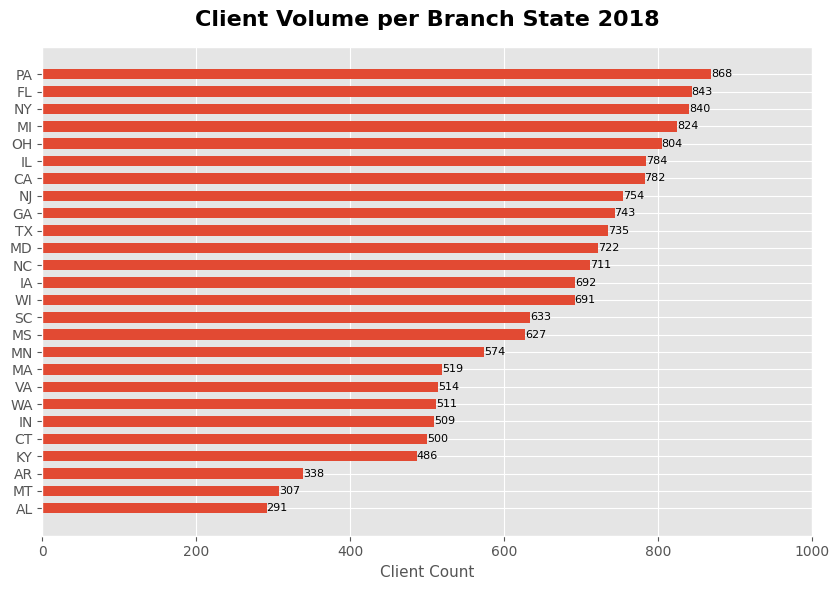

In [39]:
def view_client_volume():
    try:
        with connect_to_mysql() as cnx:
            cursor = cnx.cursor()
            cursor.execute("use creditcard_capstone")
            query = '''select br.branch_state as BRANCH_STATE, count(distinct cc.cust_ssn) as NUM_CUST
                    from cdw_sapp_branch br
                    right join cdw_sapp_credit_card cc on br.branch_code = cc.branch_code
                    group by BRANCH_STATE
                    order by NUM_CUST desc'''
            cursor.execute(query)
            data = cursor.fetchall()
            if data:
                headers = cursor.column_names
                table = tabulate(data, headers=headers,
                                 tablefmt="pretty", stralign="left")
                print(table)
                # create data visualization
                state = [row[0] for row in data]  # y-axis
                cust = [row[1] for row in data]  # x-axis
                plt.style.use('ggplot')
                plt.figure(3.2, figsize=(8.5, 6), layout='tight')
                plt.barh(state, cust, height=0.6)
                plt.title("Number of Bank Customers by State 2018",
                          fontsize=16, fontweight='bold', pad=15)
                plt.xlabel("Client Volume", fontsize=11)
                plt.xlim(0, 1000)
                plt.yticks(fontsize=10)
                # Invert the y-axis for ascending order from bottom to top
                plt.gca().invert_yaxis()
                # add customer count as labels on top of the bars
                for index, value in enumerate(cust):
                    plt.text(value, index, str(value), va='center', fontsize=8)
                plt.show()

    except Error as e:
        print(e)


view_client_volume()


3.3 - Find and plot the sum of all transactions for the top 10 customers, and which customer has the highest transaction amount.
Hint (use CUST_SSN). 

Note: Save a copy of the visualization to a folder in your github, making sure it is PROPERLY NAMED!


+-----------+------+-----------+----------------+
| CUST_SSN  | CUST | NUM_TRXNS | TOTAL_TRXN_AMT |
+-----------+------+-----------+----------------+
| 123451125 | TD   | 96        | 5633.07        |
| 123452783 | JB   | 97        | 5548.14        |
| 123453486 | PM   | 95        | 5476.08        |
| 123458668 | TV   | 99        | 5314.97        |
| 123456678 | BP   | 99        | 5261.03        |
| 123452026 | JM   | 98        | 5241.18        |
| 123452518 | AH   | 91        | 5223.96        |
| 123454933 | ME   | 96        | 5203.08        |
| 123457547 | AV   | 91        | 5149.75        |
| 123452085 | CS   | 94        | 5133.29        |
+-----------+------+-----------+----------------+


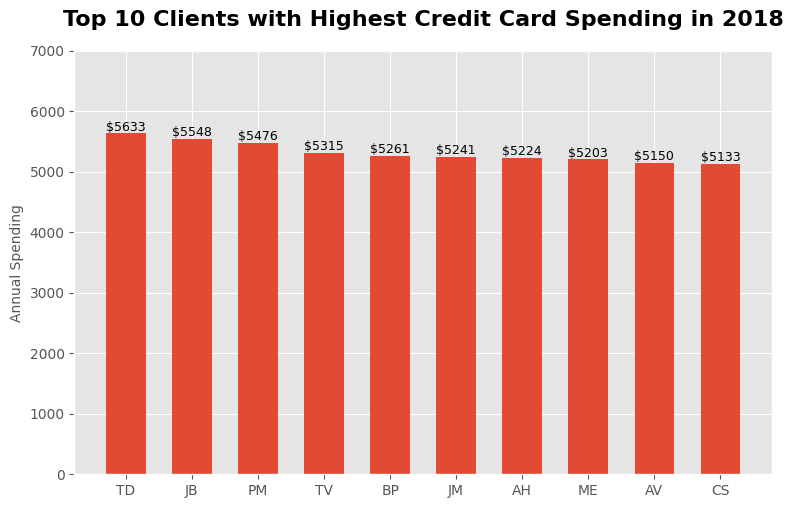

In [35]:
def view_top10_trxns():
    try:
        with connect_to_mysql() as cnx:
            cursor = cnx.cursor()
            cursor.execute("use creditcard_capstone")
            query = '''select CUST_SSN, concat(left(first_name, 1), left(last_name, 1)) as CUST, count(*) as NUM_TRXNS, round(sum(transaction_value),2) as TOTAL_TRXN_AMT
                    from cdw_sapp_credit_card cc
                    left join cdw_sapp_customer cust
                    on cc.cust_ssn = cust.ssn
                    group by CUST_SSN, CUST
                    order by TOTAL_TRXN_AMT desc, NUM_TRXNS desc
                    limit 10'''
            cursor.execute(query)
            data = cursor.fetchall()
            if data:
                headers = cursor.column_names
                table = tabulate(data, headers=headers,
                                 tablefmt="pretty", stralign="left")
                print(table)
                # create data visualization
                cust = [row[1] for row in data]  # x-axis
                trxn_amt = [row[3] for row in data]  # y-axis
                plt.style.use('ggplot')
                plt.figure(3.3, figsize=(9, 5.5))
                plt.bar(cust, trxn_amt, width=0.6)
                plt.title("Top 10 Clients with Highest Credit Card Spending in 2018",
                          fontsize=16, fontweight='bold', pad=18)
                plt.ylabel("Annual Spending", fontsize=10)
                plt.ylim(0, 7000)
                # add spending amounts as labels on top of the bars
                for x, y in zip(cust, trxn_amt):
                    plt.text(x, y, f"${round(y)}",
                             ha="center", va="bottom", fontsize=9)
                plt.show()

    except Error as e:
        print(e)


view_top10_trxns()


`Overview of LOAN Application Data API`

Banks deal in all home loans. They have a presence across all urban, semi-urban, and rural areas. Customers first apply for a home loan; after that, a company will validate the customer's eligibility for a loan.

Banks want to automate the loan eligibility process (in real time) based on customer details provided while filling out the online application form. These details are Gender, Marital Status, Education, Number of Dependents, Income, Loan Amount, Credit History, and others. To automate this process, they have the task of identifying the customer segments to those who are eligible for loan amounts so that they can specifically target these customers. Here they have provided a partial dataset.

API Endpoint: https://raw.githubusercontent.com/platformps/LoanDataset/main/loan_data.json

The above URL allows you to access information for loan application information. This dataset has all of the required fields for a loan application. You can access data from a REST API by sending an HTTP request and processing the response.


### 4. Functional Requirements - LOAN Application Dataset
4.1 - Create a Python program to GET (consume) data from the above API endpoint for the loan application dataset.

4.2 - Find the status code of the above API endpoint. Hint: status code could be 200 (request succeeded), 400 (bad request), 404 (unauthorized), 401 (not found).


In [31]:
import requests
import json
import pprint as pp


In [43]:
url = "https://raw.githubusercontent.com/platformps/LoanDataset/main/loan_data.json"
response = requests.get(url)
print("Response status code: ", response.status_code)
if response.status_code == 200:
    data = response.json()
    pp.pprint(data)


Response status code:  200
[{'Application_ID': 'LP001002',
  'Application_Status': 'Y',
  'Credit_History': 1,
  'Dependents': '0',
  'Education': 'Graduate',
  'Gender': 'Male',
  'Income': 'medium',
  'Married': 'No',
  'Property_Area': 'Urban',
  'Self_Employed': 'No'},
 {'Application_ID': 'LP001003',
  'Application_Status': 'N',
  'Credit_History': 1,
  'Dependents': '1',
  'Education': 'Graduate',
  'Gender': 'Male',
  'Income': 'medium',
  'Married': 'Yes',
  'Property_Area': 'Rural',
  'Self_Employed': 'No'},
 {'Application_ID': 'LP001005',
  'Application_Status': 'Y',
  'Credit_History': 1,
  'Dependents': '0',
  'Education': 'Graduate',
  'Gender': 'Male',
  'Income': 'low',
  'Married': 'Yes',
  'Property_Area': 'Urban',
  'Self_Employed': 'Yes'},
 {'Application_ID': 'LP001006',
  'Application_Status': 'Y',
  'Credit_History': 1,
  'Dependents': '0',
  'Education': 'Not Graduate',
  'Gender': 'Male',
  'Income': 'low',
  'Married': 'Yes',
  'Property_Area': 'Urban',
  'Self_E

4.3 - Once Python reads data from the API, utilize PySpark to load data into RDBMS (SQL). The table name should be cdw_sapp_loan_application in the database.

Note: Use the “creditcard_capstone” database.


In [44]:
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.sql import SparkSession
ss = SparkSession.builder.appName("Credit_Card_System").getOrCreate()
ss


In [46]:
# ss.read.json() only accepts a file or path as its input, hence can't use it to read json data here
df = ss.createDataFrame(data)
df.printSchema()
df.show(10, truncate=False)


root
 |-- Application_ID: string (nullable = true)
 |-- Application_Status: string (nullable = true)
 |-- Credit_History: long (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- Education: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Income: string (nullable = true)
 |-- Married: string (nullable = true)
 |-- Property_Area: string (nullable = true)
 |-- Self_Employed: string (nullable = true)

+--------------+------------------+--------------+----------+------------+------+------+-------+-------------+-------------+
|Application_ID|Application_Status|Credit_History|Dependents|Education   |Gender|Income|Married|Property_Area|Self_Employed|
+--------------+------------------+--------------+----------+------------+------+------+-------+-------------+-------------+
|LP001002      |Y                 |1             |0         |Graduate    |Male  |medium|No     |Urban        |No           |
|LP001003      |N                 |1             |1         |Gradu

In [47]:
# convert income column to title case
df = df.withColumn('Income', initcap(col('Income')))
df.show(10, truncate=False)


+--------------+------------------+--------------+----------+------------+------+------+-------+-------------+-------------+
|Application_ID|Application_Status|Credit_History|Dependents|Education   |Gender|Income|Married|Property_Area|Self_Employed|
+--------------+------------------+--------------+----------+------------+------+------+-------+-------------+-------------+
|LP001002      |Y                 |1             |0         |Graduate    |Male  |Medium|No     |Urban        |No           |
|LP001003      |N                 |1             |1         |Graduate    |Male  |Medium|Yes    |Rural        |No           |
|LP001005      |Y                 |1             |0         |Graduate    |Male  |Low   |Yes    |Urban        |Yes          |
|LP001006      |Y                 |1             |0         |Not Graduate|Male  |Low   |Yes    |Urban        |No           |
|LP001008      |Y                 |1             |0         |Graduate    |Male  |Medium|No     |Urban        |No           |


In [48]:
# load data from df into new table in mysql db
df.write.format("jdbc")\
    .mode("append")\
    .options(user=os.environ.get("MYSQL_DB_USER"),
             password=os.environ.get("MYSQL_DB_PW"),
             url="jdbc:mysql://localhost:3306/creditcard_capstone",
             dbtable="creditcard_capstone.CDW_SAPP_LOAN_APPLICATION")\
    .save()


In [ ]:
#  MySQL  localhost:33060+ ssl  creditcard_capstone  SQL > SHOW TABLES;
# +-------------------------------+
# | Tables_in_creditcard_capstone |
# +-------------------------------+
# | cdw_sapp_branch               |
# | cdw_sapp_credit_card          |
# | cdw_sapp_customer             |
# | cdw_sapp_loan_application     |  <---
# +-------------------------------+
# 4 rows in set (0.0020 sec)


### 5. Functional Requirements - Data Analysis and Visualization for LOAN Application
After the data is loaded into the database, the business analyst team wants to analyze and visualize the data.

Use Python libraries for the below requirements:

5.1 - Find and plot the percentage of applications approved for self-employed applicants.

Note: Save a copy of the visualization to a folder in your github, making sure it is PROPERLY NAMED!


In [3]:
import mysql.connector
from tabulate import tabulate
import os
import matplotlib.pyplot as plt


In [4]:
cnx = mysql.connector.connect(host='localhost',
                              user=os.environ.get('MYSQL_DB_USER'),
                              password=os.environ.get('MYSQL_DB_PW'))
cursor = cnx.cursor()
cursor.execute("use creditcard_capstone")


+---------------+----------+----------+
| self_employed | approved | rejected |
+---------------+----------+----------+
| No            | 301      | 140      |
| Yes           | 46       | 24       |
+---------------+----------+----------+
+---------------+------------+------------+
| self_employed | approved % | rejected % |
+---------------+------------+------------+
| No            | 68.25      | 31.75      |
| Yes           | 65.71      | 34.29      |
+---------------+------------+------------+


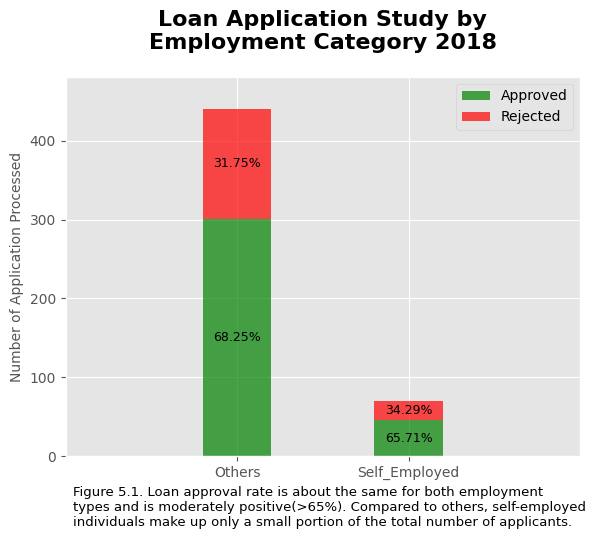

In [10]:
q1_ct = '''select self_employed, round(sum(case when application_status='Y' then 1 else 0 end), 2) as approved,
     round(sum(case when application_status='N' then 1 else 0 end), 2) as rejected
     from cdw_sapp_loan_application 
     group by self_employed'''
cursor.execute(q1_ct)
ct = cursor.fetchall()
headers = cursor.column_names
table_ct = tabulate(ct, headers=headers, tablefmt="pretty", stralign="left")
print(table_ct)

type = ['Others', 'Self_Employed']
approved = [row[1] for row in ct]
rejected = [row[2] for row in ct]
plt.style.use('ggplot')
plt.figure(5.1, figsize=(6,5), layout='tight')
plt.bar(type, approved, label='Approved', width=0.4, color='green', alpha=0.7)
plt.bar(type, rejected, label='Rejected', width=0.4, color='red', alpha=0.7, bottom=approved)
plt.title("Loan Application Study by\nEmployment Category 2018", fontsize=16, fontweight='bold', pad=20)
plt.xlim(-1, len(type))
plt.ylabel("Number of Application Processed", fontsize=10)
plt.ylim(0, max(approved)+max(rejected)+40)
plt.legend()
caption = "Figure 5.1. Loan approval rate is about the same for both employment \ntypes and is moderately positive(>65%). Compared to others, self-employed \nindividuals make up only a small portion of the total number of applicants. "
plt.figtext(0.13, -0.025, caption, ha='left', va='center', fontsize=9.5)

q1_per = '''select self_employed, round(sum(case when application_status='Y' then 1 else 0 end)/count(*)*100, 2) as 'approved %',
     round(sum(case when application_status='N' then 1 else 0 end)/count(*)*100, 2) as 'rejected %'
     from cdw_sapp_loan_application 
     group by self_employed'''
cursor.execute(q1_per)
per = cursor.fetchall()
headers = cursor.column_names
table_per = tabulate(per, headers=headers, tablefmt="pretty", stralign="left")
print(table_per)
type = ['Others', 'Self_Employed']
approved_per = [row[1] for row in per]
rejected_per = [row[2] for row in per]
# add approval and rejction rate as labels onto the bars
for i, (app_ct, rej_ct, app_per, rej_per) in enumerate(zip(approved, rejected, approved_per, rejected_per)):
    plt.text(i, app_ct/2, f'{app_per}%', ha='center', va='center', fontsize=9)
    plt.text(i, app_ct + rej_ct/2, f'{rej_per}%',
             ha='center', va='center', fontsize=9)
plt.show()


+---------------+--------------------+-------------------+
| self_employed | application_status | Application_Count |
+---------------+--------------------+-------------------+
| Yes           | Y                  | 46                |
| Yes           | N                  | 24                |
+---------------+--------------------+-------------------+


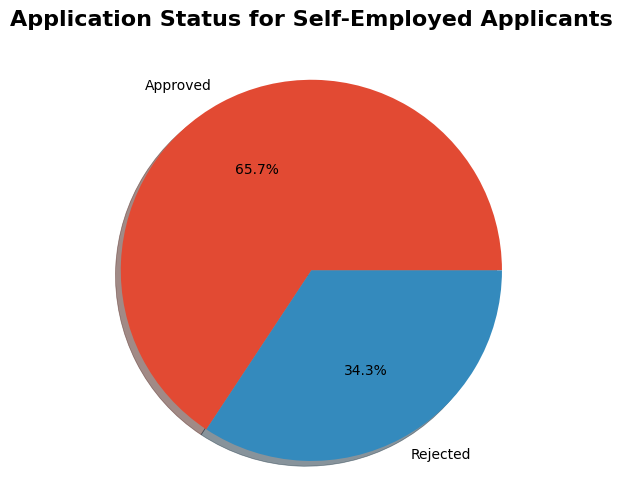

In [95]:
# below code is replaced with above code
q1 = '''select self_employed, application_status, count(application_status) as application_count 
    from cdw_sapp_loan_application 
    where self_employed ='Yes' 
    group by application_status'''
cursor.execute(q1)
data1 = cursor.fetchall()
headers = cursor.column_names
table = tabulate(data1, headers=headers, tablefmt="pretty", stralign="left")
print(table)
status = [row[1] for row in data1]
count = [row[2] for row in data1]
plt.style.use('ggplot')
plt.figure(4, figsize=(6, 5), layout='tight')
plt.pie(count, labels=['Approved', 'Rejected'], autopct='%1.1f%%', shadow=True)
plt.title("Application Status for Self-Employed Applicants",
          fontsize=16, fontweight='bold', pad=25)
plt.axis('equal')
plt.show()



5.2 - Find the percentage of rejection for married male applicants.

Note: Save a copy of the visualization to a folder in your github, making sure it is PROPERLY NAMED!


+--------+---------+--------------------+-------------------+
| gender | married | application_status | Application_Count |
+--------+---------+--------------------+-------------------+
| Male   | Yes     | N                  | 87                |
| Male   | Yes     | Y                  | 219               |
+--------+---------+--------------------+-------------------+


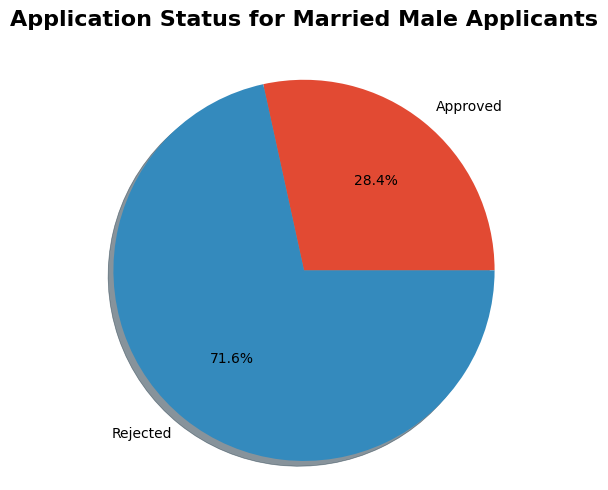

In [127]:
q2 = '''select gender, married, application_status, count(application_status) as Application_Count 
    from cdw_sapp_loan_application 
    where gender = 'Male' and married = 'Yes' 
    group by application_status'''
cursor.execute(q2)
data2 = cursor.fetchall()
headers = cursor.column_names
table = tabulate(data2, headers=headers, tablefmt="pretty", stralign="left")
print(table)

status = [row[2] for row in data2]
count = [row[3] for row in data2]

plt.style.use('ggplot')
plt.figure(4, figsize=(6, 5), layout='tight')
plt.pie(count, labels=['Approved', 'Rejected'], autopct='%1.1f%%', shadow=True)
plt.title("Application Status for Married Male Applicants",
          fontsize=16, fontweight='bold', pad=25)
plt.axis('equal')
plt.show()


+----------------+----------+----------+
| married_gender | approved | rejected |
+----------------+----------+----------+
| No,Female      | 40       | 26       |
| No,Male        | 71       | 43       |
| Yes,Female     | 17       | 8        |
| Yes,Male       | 219      | 87       |
+----------------+----------+----------+
+----------------+------------+------------+
| married_gender | approved % | rejected % |
+----------------+------------+------------+
| No,Female      | 60.61      | 39.39      |
| No,Male        | 62.28      | 37.72      |
| Yes,Female     | 68.00      | 32.00      |
| Yes,Male       | 71.57      | 28.43      |
+----------------+------------+------------+


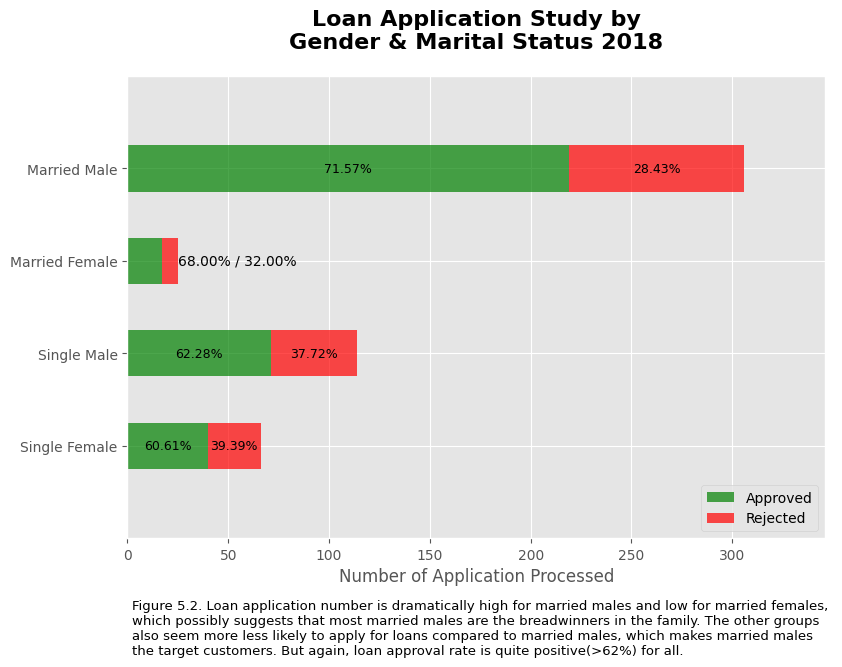

In [39]:
q2_ct = '''select concat(married, (","), gender) as married_gender, round(sum(case when application_status='Y' then 1 else 0 end), 2) as approved,
     round(sum(case when application_status='N' then 1 else 0 end), 2) as rejected
     from cdw_sapp_loan_application 
     group by married_gender
     order by married_gender'''
cursor.execute(q2_ct)
ct = cursor.fetchall()
headers = cursor.column_names
table_ct = tabulate(ct, headers=headers, tablefmt="pretty", stralign="left")
print(table_ct)
# create a horizontal bar graph
type = ['Single Female', 'Single Male', 'Married Female', 'Married Male']
approved = [row[1] for row in ct]
rejected = [row[2] for row in ct]
plt.style.use('ggplot')
plt.figure(5.2, figsize=(9, 6))
plt.barh(type, approved, label='Approved',
         height=0.5, color='green', alpha=0.7)
plt.barh(type, rejected, label='Rejected', height=0.5,
         color='red', alpha=0.7, left=approved)
# customize the plot
plt.xlabel('Number of Application Processed')
plt.xlim(-0, max(approved)+max(rejected)+40)
plt.ylim(-1, len(type))
plt.title("Loan Application Study by\nGender & Marital Status 2018",
          fontsize=16, fontweight='bold', pad=20)
plt.legend(loc='lower right')
caption = "Figure 5.2. Loan application number is dramatically high for married males and low for married females, \nwhich possibly suggests that most married males are the breadwinners in the family. The other groups \nalso seem more less likely to apply for loans compared to married males, which makes married males \nthe target customers. But again, loan approval rate is quite positive(>62%) for all."
plt.figtext(0.13, -0.04, caption, ha='left', va='center', fontsize=9.5)

q2_percentage = '''select concat(married, (","), gender) as married_gender, round(sum(case when application_status='Y' then 1 else 0 end)/count(*)*100, 2) as 'approved %',
     round(sum(case when application_status='N' then 1 else 0 end)/count(*)*100, 2) as 'rejected %'
     from cdw_sapp_loan_application 
     group by married_gender
     order by married_gender'''
cursor.execute(q2_percentage)
percentage = cursor.fetchall()
headers = cursor.column_names
table_percentage = tabulate(
    percentage, headers=headers, tablefmt="pretty", stralign="left")
print(table_percentage)
approved_percentage = [row[1] for row in percentage]
rejected_percentage = [row[2] for row in percentage]
# add data values to the bars
for i, (app_ct, rej_ct, app_per, rej_per) in enumerate(zip(approved, rejected, approved_percentage, rejected_percentage)):
    # conditionally add percentage labels if the bar width is greater than the minimum width
    if app_ct < 40 and rej_ct < 40:
        intersection = app_ct + rej_ct
        plt.text(intersection, i, f'{app_per}% / {rej_per}%',
                 ha='left', va='center', color='black')
    else:
        plt.text(app_ct/2, i, f'{app_per}%',
                 ha='center', va='center', fontsize=9)
        plt.text(app_ct + rej_ct/2, i,
                 f'{rej_per}%', ha='center', va='center', fontsize=9)
# show the plot
plt.show()


+-----------------------+----------+----------+
| married_self_employed | approved | rejected |
+-----------------------+----------+----------+
| No,No                 | 62.42    | 37.58    |
| Yes,No                | 71.48    | 28.52    |
| Yes,Yes               | 70.21    | 29.79    |
| No,Yes                | 56.52    | 43.48    |
+-----------------------+----------+----------+


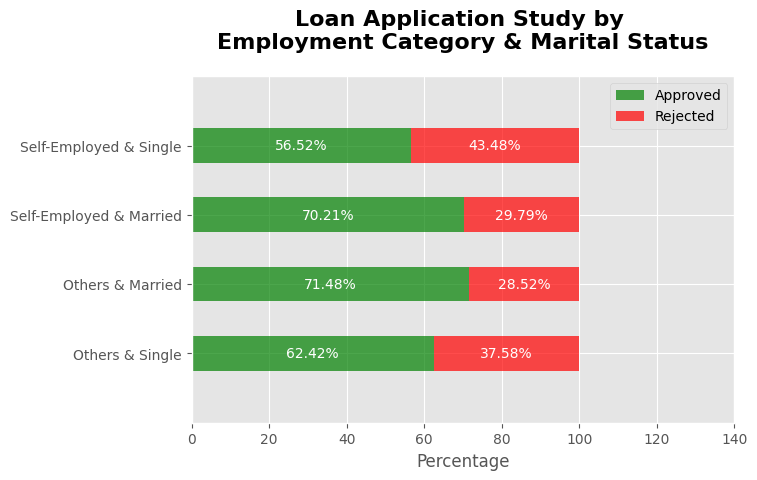

In [142]:
# # wrong query
# q2 = '''select concat(married, (","), self_employed) as married_self_employed, round(sum(case when application_status='Y' then 1 else 0 end)/count(*)*100, 2) as approved,
#      round(sum(case when application_status='N' then 1 else 0 end)/count(*)*100, 2) as rejected
#      from cdw_sapp_loan_application
#      group by married_self_employed'''
# cursor.execute(q2)
# data2 = cursor.fetchall()
# headers = cursor.column_names
# table = tabulate(data2, headers = headers, tablefmt = "pretty", stralign = "left")
# print(table)
# type = ['Others & Single', 'Others & Married', 'Self-Employed & Married', 'Self-Employed & Single']
# approved = [row[1] for row in data2]
# rejected = [row[2] for row in data2]
# # create a horizontal bar graph
# plt.style.use('ggplot')
# plt.figure(4, figsize=(7,4.5))
# plt.barh(type, approved, label='Approved', height=0.5, color='green', alpha=0.7)
# plt.barh(type, rejected, label='Rejected', height=0.5, color='red', alpha=0.7, left=approved)
# # customize the plot
# plt.xlabel('Percentage')
# plt.xlim(-0, 140)
# plt.ylim(-1, len(type))
# plt.title("Loan Application Study by \nEmployment Category & Marital Status", fontsize=16, fontweight='bold', pad=20)
# plt.legend(loc='upper right')
# # add data values to the bars
# for i, (app_val, rej_val) in enumerate(zip(approved, rejected)):
#     plt.text(app_val / 2, i, f'{app_val:.2f}%', ha='center', va='center', color='white')
#     plt.text(app_val + rej_val / 2, i, f'{rej_val:.2f}%', ha='center', va='center', color='white')
# # show the plot
# plt.show()



5.3 - Find and plot the top three months with the largest volume of transaction data.

Note: Save a copy of the visualization to a folder in your github, making sure it is PROPERLY NAMED!


+-------+-------------+
| MONTH | TRXN_VOLUME |
+-------+-------------+
| Feb   | 3959        |
| May   | 3946        |
| Oct   | 3946        |
| Dec   | 3936        |
| Jul   | 3935        |
| Nov   | 3901        |
| Sep   | 3886        |
| Aug   | 3861        |
| Mar   | 3851        |
| Apr   | 3840        |
| Jun   | 3819        |
| Jan   | 3814        |
+-------+-------------+


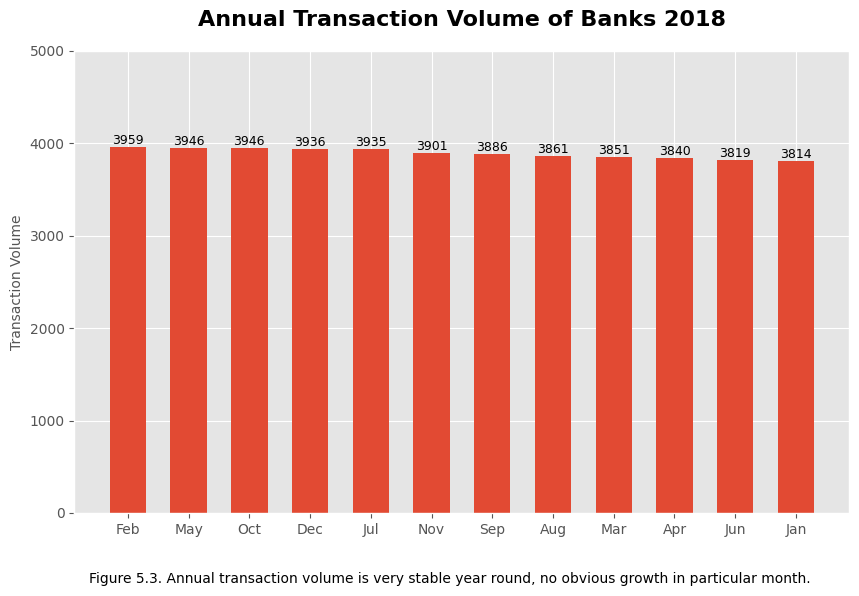

In [12]:
q3 = '''select date_format(timeid, '%b') as MONTH, count(distinct transaction_id) as TRXN_VOLUME 
    from cdw_sapp_credit_card 
    group by MONTH 
    order by TRXN_VOLUME desc'''
cursor.execute(q3)
data3 = cursor.fetchall()
headers = cursor.column_names
table = tabulate(data3, headers=headers, tablefmt="pretty", stralign="left")
print(table)
month = [row[0] for row in data3]  # x-axis
trxn_vol = [row[1] for row in data3]  # y-axis
plt.style.use('ggplot')
plt.figure(5.3, figsize=(10, 6))
plt.bar(month, trxn_vol, width=0.6)
plt.title("Annual Transaction Volume of Banks 2018",
          fontsize=16, fontweight='bold', pad=18)
plt.ylabel("Transaction Volume", fontsize=10)
plt.ylim(0, 5000)
caption = "Figure 5.3. Annual transaction volume is very stable year round, no obvious growth in particular month."
plt.figtext(0.14, 0, caption, ha='left', va='center', fontsize=10)
# add spending amounts as labels on top of the bars
for x, y in zip(month, trxn_vol):
    plt.text(x, y, str(y), ha="center", va="bottom", fontsize=9)
plt.show()



5.4 - Find and plot which branch processed the highest total dollar value of healthcare transactions.

Note: Save a copy of the visualization to a folder in your github, making sure it is PROPERLY NAMED!. 


+-------------+------------------------+----------------+
| BRANCH_CODE | BRANCH                 | TOTAL_TRXN_VAL |
+-------------+------------------------+----------------+
| 25          | Example Bank 25 in MI  | 4370.18        |
| 60          | Example Bank 60 in VA  | 4072.04        |
| 83          | Example Bank 83 in WI  | 4003.37        |
| 36          | Example Bank 36 in AR  | 3823.87        |
| 111         | Example Bank 111 in NC | 3720.27        |
| 90          | Example Bank 90 in OH  | 3697.16        |
| 21          | Example Bank 21 in WA  | 3651.74        |
| 109         | Example Bank 109 in IA | 3603.67        |
| 42          | Example Bank 42 in OH  | 3603.25        |
| 70          | Example Bank 70 in MA  | 3594.35        |
+-------------+------------------------+----------------+


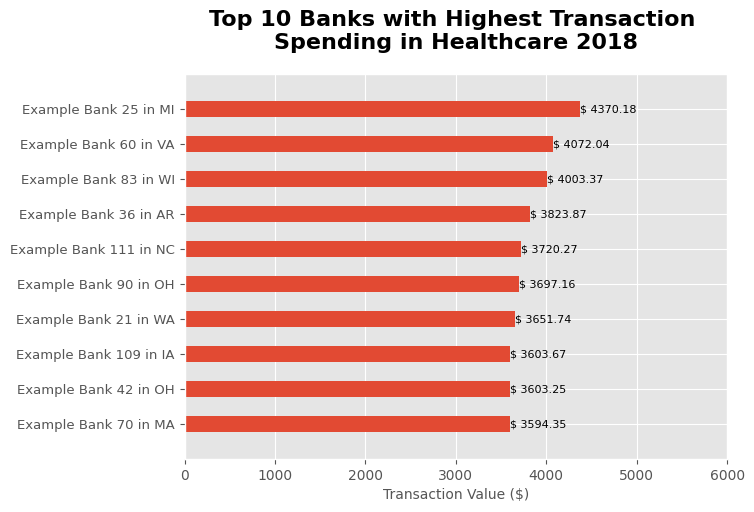

In [117]:
q4 = '''select cc.branch_code as BRANCH_CODE, concat(br.branch_name, ' ', br.branch_code, ' in ', br.branch_state) as BRANCH, round(sum(transaction_value),2) as TOTAL_TRXN_VAL
    from cdw_sapp_credit_card cc
    inner join cdw_sapp_branch br
    on cc.branch_code = br.branch_code
    where cc.transaction_type = 'Healthcare'
    group by cc.branch_code, BRANCH
    order by TOTAL_TRXN_VAL desc limit 10'''
cursor.execute(q4)
data4 = cursor.fetchall()
headers = cursor.column_names
table = tabulate(data4, headers=headers, tablefmt="pretty", stralign="left")
print(table)
branch = [row[1] for row in data4]  # y-axis
trxn_val = [row[2] for row in data4]  # x-axis
plt.style.use('ggplot')
plt.figure(7, figsize=(7, 5))
plt.barh(branch, trxn_val, height=0.45)
plt.title("Top 10 Banks with Highest Transaction \nSpending in Healthcare 2018",
          loc='center', fontsize=16, fontweight='bold', pad=18)
plt.xlabel("Transaction Value ($)", fontsize=10)
plt.xlim(0, 6000)
plt.yticks(range(len(branch)), fontsize=9.5)
plt.ylim(-1, len(branch))
# Invert the y-axis for ascending order from bottom to top
plt.gca().invert_yaxis()
# add customer count as labels on top of the bars
for index, value in enumerate(trxn_val):
    plt.text(value, index, f"$ {value}", va='center', fontsize=8)
plt.show()


+-------------+------------------------+----------------+
| BRANCH_CODE | BRANCH                 | TOTAL_TRXN_VAL |
+-------------+------------------------+----------------+
| 25          | Example Bank 25 in MI  | 4370.18        |
| 60          | Example Bank 60 in VA  | 4072.04        |
| 83          | Example Bank 83 in WI  | 4003.37        |
| 36          | Example Bank 36 in AR  | 3823.87        |
| 111         | Example Bank 111 in NC | 3720.27        |
| 90          | Example Bank 90 in OH  | 3697.16        |
| 21          | Example Bank 21 in WA  | 3651.74        |
| 109         | Example Bank 109 in IA | 3603.67        |
| 42          | Example Bank 42 in OH  | 3603.25        |
| 70          | Example Bank 70 in MA  | 3594.35        |
+-------------+------------------------+----------------+


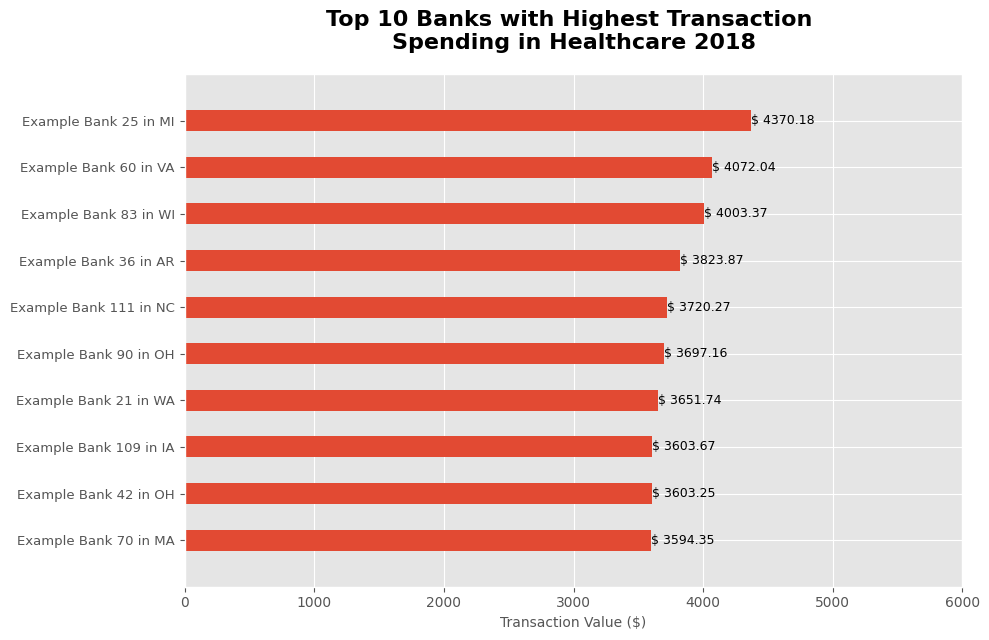

In [209]:
# refactord code from code above
def reuse(q):
    try:
        with connect_to_mysql() as cnx:
            cursor = cnx.cursor()
            cursor.execute("use creditcard_capstone")
            query = q
            cursor.execute(query)
            data = cursor.fetchall()
            headers = cursor.column_names
            table = tabulate(data, headers=headers,
                             tablefmt="pretty", stralign="left")
            print(table)

    except Error as e:
        print(e)


def get_data():
    q = '''select cc.branch_code as BRANCH_CODE, concat(br.branch_name, ' ', br.branch_code, ' in ', br.branch_state) as BRANCH, round(sum(transaction_value),2) as TOTAL_TRXN_VAL
    from cdw_sapp_credit_card cc
    inner join cdw_sapp_branch br
    on cc.branch_code = br.branch_code
    where cc.transaction_type = 'Healthcare'
    group by cc.branch_code, BRANCH
    order by TOTAL_TRXN_VAL desc limit 10'''
    reuse(q)
    branch = [row[1] for row in data4]  # y-axis
    trxn_val = [row[2] for row in data4]  # x-axis
    plt.style.use('ggplot')
    plt.figure(5.4, figsize=(10, 6.5), layout='tight')
    plt.barh(branch, trxn_val, height=0.45)
    plt.title("Top 10 Banks with Highest Transaction \nSpending in Healthcare 2018",
              loc='center', fontsize=16, fontweight='bold', pad=18)
    plt.xlabel("Transaction Value ($)", fontsize=10)
    plt.xlim(0, 6000)
    plt.yticks(range(len(branch)), fontsize=9.5)
    plt.ylim(-1, len(branch))
    # Invert the y-axis for ascending order from bottom to top
    plt.gca().invert_yaxis()
    # add customer count as labels on top of the bars
    for index, value in enumerate(trxn_val):
        plt.text(value, index, f"$ {value}", va='center', fontsize=9)
    plt.show()


get_data()


In [4]:
ss.stop()


In [5]:
# Check active session using SparkSession.getActiveSession()
if SparkSession.getActiveSession() is not None:
    print("An active Spark session is available.")
else:
    print("No active Spark session found.")


No active Spark session found.
